In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [98]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.3,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -.4,
                   'pi': -.2,
                   'theta': .53}
    
time_dim = 37000
sim_dim = 500
innov_dim = 250

In [99]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [100]:
def compute_moments(delta, rho, scale, phi, pi, theta):
    
    vol_mean = scale * delta / (1 - rho)
    vol_var = (2 * scale * rho * vol_mean + scale**2 * delta) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, scale=scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(delta=delta, rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [101]:
compute_moments(**true_params)

{'return_mean': 0.8537663581319141,
 'return_var': 14.689427622788468,
 'vol_mean': 4.419473684210527,
 'vol_var': 72.33980609418288}

In [102]:
vl.compute_gamma(**true_params)

0.21681989308137542

In [103]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.4,
 'pi': -0.2,
 'theta': 0.53,
 'gamma': 0.21681989308137542,
 'beta': 0.33791607344422514,
 'psi': -0.19379337681495,
 'zeta': 0.84}

In [96]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.001,
 'pi': -0.2,
 'theta': 0.53}

In [97]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.001,
 'pi': -0.2,
 'theta': 0.53,
 'gamma': 0.0004624522981223145,
 'beta': 0.0005828948048200722,
 'psi': -0.030421453442037394,
 'zeta': 0.999999}

## We start by examining the distributions of simulated data

In [87]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [89]:
data.corr()

,vol,rtn
vol,1.000000,-0.128279
rtn,-0.128279,1.000000


In [71]:
omega, omega_cov = vl.estimate_params(data)

In [72]:
omega

{'gamma': 0.046754158967840714,
 'beta': 0.059793613637699444,
 'psi': -0.071238486473285,
 'zeta': 0.9957886954572353,
 'delta': 0.26237780217047113,
 'rho': 0.8154765769202742,
 'scale': 3.0915738667855015}

In [73]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,3.426251e-09,0.000000,-3.014418e-09,-2.739325e-09,0.000000,0.000000,0.000000
delta,0.000000e+00,0.000033,0.000000e+00,0.000000e+00,-0.000019,-0.000087,0.000000
gamma,-3.014418e-09,0.000000,1.170002e-08,3.486950e-10,0.000000,0.000000,0.000000
psi,-2.739325e-09,0.000000,3.486950e-10,6.134881e-06,0.000000,0.000000,0.000000
rho,0.000000e+00,-0.000019,0.000000e+00,0.000000e+00,0.000046,-0.000019,0.000000
scale,0.000000e+00,-0.000087,0.000000e+00,0.000000e+00,-0.000019,0.002326,0.000000
zeta,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000053


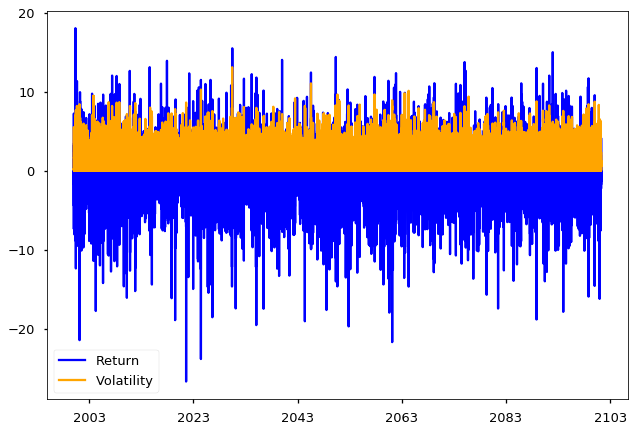

In [104]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [105]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,2.369872,-0.385418
rtn,-0.385418,4.544360


In [106]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.4,
 'pi': -0.2,
 'theta': 0.53,
 'gamma': 0.21681989308137542,
 'beta': 0.33791607344422514,
 'psi': -0.19379337681495,
 'zeta': 0.84}

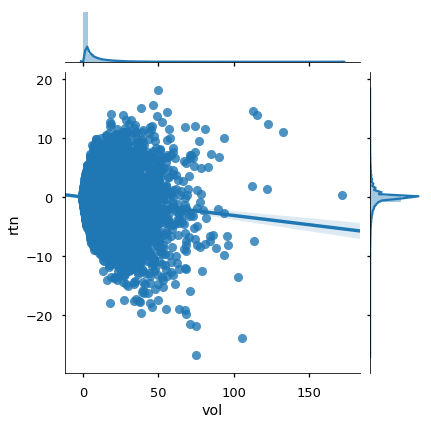

In [107]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [108]:
true_params['delta']

0.27

In [109]:
true_params['scale']

3.11

In [110]:
data.describe()

,vol,rtn
count,37000.000000,37000.000000
mean,4.560283,-0.127653
std,8.770123,2.131750
min,0.000010,-26.706338
25%,0.072367,-0.557151
50%,0.961919,0.004335
75%,4.990524,0.421485
max,171.949576,18.061444


## I now estimate all of the parameters

In [111]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [112]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [113]:
estimator(data_arr[0])

({'gamma': 0.2167411775999149,
  'beta': 0.33793166462631014,
  'psi': -0.19258708475118377,
  'zeta': 0.8493579624233443,
  'delta': 0.2699115437093498,
  'rho': 0.8122833302372886,
  'scale': 3.0969672779079054,
  'phi': -0.3703349632420146,
  'pi': -0.3058084225182827,
  'theta': 0.5313795883933781},
                beta     delta         gamma       phi            pi  \
 beta   2.677392e-09  0.000000 -2.208942e-09       NaN           NaN   
 delta  0.000000e+00  0.000034  0.000000e+00       NaN           NaN   
 gamma -2.208942e-09  0.000000  9.030802e-09       NaN           NaN   
 phi             NaN       NaN           NaN  0.000073 -1.512014e-05   
 pi              NaN       NaN           NaN -0.000015  1.633484e-05   
 psi   -2.180618e-09  0.000000  1.795295e-10       NaN           NaN   
 rho    0.000000e+00 -0.000019  0.000000e+00       NaN           NaN   
 scale  0.000000e+00 -0.000086  0.000000e+00       NaN           NaN   
 theta           NaN       NaN           NaN  0

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


In [ ]:
true_params

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
 filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)

In [ ]:
filename

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)